# Convolutional Neural Networks

## Project: Write an Algorithm for Landmark Classification

In this notebook, I will create a CNN that classifies landmarks.  I will train this CNN from scratch and compare its performance to a CNN that uses transfer learning. I will try to achieve an accuracy of at least 50%.

Although 50% may seem low at first glance, it seems more reasonable after realizing how difficult of a problem this is. Many times, an image that is taken at a landmark captures a fairly mundane image of an animal or plant, like in the following picture.

<img src="static_images/train/00.Haleakala_National_Park/084c2aa50d0a9249.jpg" alt="Bird in Haleakalā National Park" style="width: 400px;"/>

Just by looking at that image alone, would you have been able to guess that it was taken at the Haleakalā National Park in Hawaii?

An accuracy of 50% is significantly better than random guessing, which would provide an accuracy of just 2% (100% / 50 classes). 

---
## <img src="static_images/icons/noun-advance-2109145.png" alt=">" style="width:50px"/> Step 0: Setting up

The following cells make sure that the environment is setup correctly, download the data if you don't have it already, and also check that your GPU is available and ready to go. You have to execute them every time you restart your notebook.

In [20]:
# Install requirements
!pip install -r requirements.txt | grep -v "already satisfied"


[notice] A new release of pip is available: 23.0 -> 23.2.1
[notice] To update, run: pip install --upgrade pip


In [21]:
from src.helpers import setup_env

# If running locally, this will download dataset (make sure you have at 
# least 2 Gb of space on your hard drive)
setup_env()

GPU available
Dataset already downloaded. If you need to re-download, please delete the directory landmark_images
Reusing cached mean and std


---
## <img src="static_images/icons/noun-advance-2109145.png" alt=">" style="width:50px"/> Step 1: Data

In this and the following steps I will execute some tests to make sure the code works as intended. 


In [22]:
!pytest -vv src/data.py -k data_loaders

============================= test session starts ==============================
platform linux -- Python 3.9.16, pytest-7.1.1, pluggy-1.0.0 -- /opt/conda/bin/python3.9
cachedir: .pytest_cache
rootdir: /root
plugins: anyio-3.7.1
collected 4 items / 1 deselected / 3 selected                                  

src/data.py::test_data_loaders_keys PASSED                               [ 33%]
src/data.py::test_data_loaders_output_type PASSED                        [ 66%]
src/data.py::test_data_loaders_output_shape PASSED                       [100%]

=============================== warnings summary ===============================
../opt/conda/lib/python3.9/site-packages/jupyter_client/connect.py:20
  /opt/conda/lib/python3.9/site-packages/jupyter_client/connect.py:20: DeprecationWarning: Jupyter is migrating its paths to use standard platformdirs
  given by the platformdirs library.  To remove this warning and
  see the appropriate new directories, set the environment variable
  `JUPYTER_PLA

<img src="static_images/icons/noun-question-mark-869751.png" alt="?" style="width:25px"/> **Question:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?

<img src="static_images/icons/noun-answer-3361020.png" alt=">" style="width:25px"/> **Answer**: My code first resizes the image to 256 and then crops to 224. I picked 224 as the input size because it is the recommended input size for using pytorch's pre-trained models. I did decide to augment the dataset via RandAugment, a typical set of augmentations for natural images. I added this augmentation with the goal of improving my model's robustness, thus improving test accuracy.

### Visualize a Batch of Training Data


In [23]:
!pytest -vv src/data.py -k visualize_one_batch

============================= test session starts ==============================
platform linux -- Python 3.9.16, pytest-7.1.1, pluggy-1.0.0 -- /opt/conda/bin/python3.9
cachedir: .pytest_cache
rootdir: /root
plugins: anyio-3.7.1
collected 4 items / 3 deselected / 1 selected                                  

src/data.py::test_visualize_one_batch PASSED                             [100%]

=============================== warnings summary ===============================
../opt/conda/lib/python3.9/site-packages/jupyter_client/connect.py:20
  /opt/conda/lib/python3.9/site-packages/jupyter_client/connect.py:20: DeprecationWarning: Jupyter is migrating its paths to use standard platformdirs
  given by the platformdirs library.  To remove this warning and
  see the appropriate new directories, set the environment variable
  `JUPYTER_PLATFORM_DIRS=1` and then run `jupyter --paths`.
  The use of platformdirs will be the default in `jupyter_core` v6
    from jupyter_core.paths import jupyter_data

Visualizing the output of the data loader is a great way to ensure that the data loading and preprocessing (including transforms such as rotations, translations, color transforms...) are working as expected.

Reusing cached mean and std
Dataset mean: tensor([0.4638, 0.4725, 0.4687]), std: tensor([0.2699, 0.2706, 0.3018])


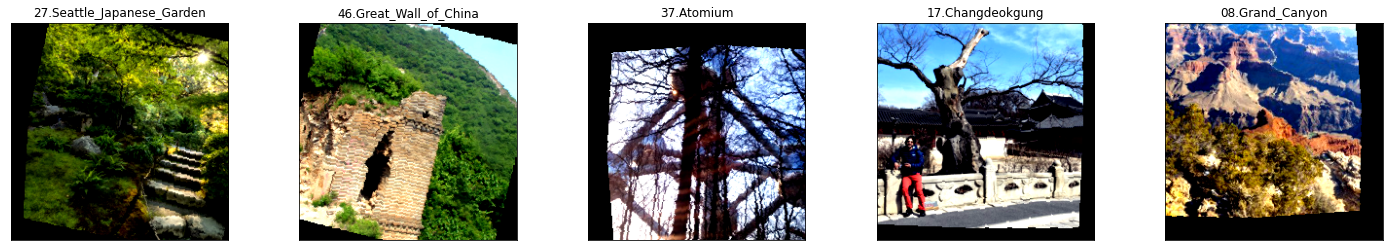

In [24]:
%matplotlib inline
from src.data import visualize_one_batch, get_data_loaders

# use get_data_loaders to get the data_loaders dictionary. Use a batch_size
# of 5, a validation size of 0.01 and num_workers=-1 (all CPUs)
data_loaders = get_data_loaders(batch_size=5, valid_size=0.01)

visualize_one_batch(data_loaders)

---
## <img src="static_images/icons/noun-advance-2109145.png" alt=">" style="width:50px"/> Step 2: Define model


In [25]:
!pytest -vv src/model.py

============================= test session starts ==============================
platform linux -- Python 3.9.16, pytest-7.1.1, pluggy-1.0.0 -- /opt/conda/bin/python3.9
cachedir: .pytest_cache
rootdir: /root
plugins: anyio-3.7.1
collected 1 item                                                               

src/model.py::test_model_construction PASSED                             [100%]

=============================== warnings summary ===============================
src/model.py::test_model_construction
  /opt/conda/lib/python3.9/site-packages/jupyter_client/connect.py:20: DeprecationWarning: Jupyter is migrating its paths to use standard platformdirs
  given by the platformdirs library.  To remove this warning and
  see the appropriate new directories, set the environment variable
  `JUPYTER_PLATFORM_DIRS=1` and then run `jupyter --paths`.
  The use of platformdirs will be the default in `jupyter_core` v6
    from jupyter_core.paths import jupyter_data_dir, jupyter_runtime_dir, secur

<img src="static_images/icons/noun-question-mark-869751.png" alt="?" style="width:25px"/> **Question**: Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

<img src="static_images/icons/noun-answer-3361020.png" alt=">" style="width:25px"/> __Answer:__ I decided to use 5 convolutional layers so that my model could be sufficiently expressive. I used dropout layers to reduce my model's tendency to overfit the training data. I made my model output a 50-dimensional vector to match with the 50 available landmark classes. I used the Adam optimizer because it is a good general optimizer. I used the categorical crossentropy loss function because it is a good general loss function for classification problems. 

---
## <img src="static_images/icons/noun-advance-2109145.png" alt=">" style="width:50px"/> Step 3: define loss and optimizer


In [26]:
!pytest -vv src/optimization.py -k get_loss

============================= test session starts ==============================
platform linux -- Python 3.9.16, pytest-7.1.1, pluggy-1.0.0 -- /opt/conda/bin/python3.9
cachedir: .pytest_cache
rootdir: /root
plugins: anyio-3.7.1
collected 7 items / 6 deselected / 1 selected                                  

src/optimization.py::test_get_loss PASSED                                [100%]

======================= 1 passed, 6 deselected in 0.56s ========================


In [27]:
!pytest -vv src/optimization.py -k get_optimizer

============================= test session starts ==============================
platform linux -- Python 3.9.16, pytest-7.1.1, pluggy-1.0.0 -- /opt/conda/bin/python3.9
cachedir: .pytest_cache
rootdir: /root
plugins: anyio-3.7.1
collected 7 items / 1 deselected / 6 selected                                  

src/optimization.py::test_get_optimizer_type PASSED                      [ 16%]
src/optimization.py::test_get_optimizer_is_linked_with_model PASSED      [ 33%]
src/optimization.py::test_get_optimizer_returns_adam PASSED              [ 50%]
src/optimization.py::test_get_optimizer_sets_learning_rate PASSED        [ 66%]
src/optimization.py::test_get_optimizer_sets_momentum PASSED             [ 83%]
src/optimization.py::test_get_optimizer_sets_weight_decat PASSED         [100%]

======================= 6 passed, 1 deselected in 0.57s ========================


---
## <img src="static_images/icons/noun-advance-2109145.png" alt=">" style="width:50px"/> Step 4: Train and Validate the Model

> <img src="static_images/icons/noun-info-2558213.png" alt="?" style="width:25px"/> Testing ML code is notoriously difficult. The tests in this section merely exercise the functions , so it will help in catching glaring problems but it won't guarantee that the training code is bug-free. 

In [28]:
!pytest -vv src/train.py -k train_one_epoch

============================= test session starts ==============================
platform linux -- Python 3.9.16, pytest-7.1.1, pluggy-1.0.0 -- /opt/conda/bin/python3.9
cachedir: .pytest_cache
rootdir: /root
plugins: anyio-3.7.1
collected 4 items / 3 deselected / 1 selected                                  

src/train.py::test_train_one_epoch PASSED                                [100%]

=============================== warnings summary ===============================
../opt/conda/lib/python3.9/site-packages/jupyter_client/connect.py:20
  /opt/conda/lib/python3.9/site-packages/jupyter_client/connect.py:20: DeprecationWarning: Jupyter is migrating its paths to use standard platformdirs
  given by the platformdirs library.  To remove this warning and
  see the appropriate new directories, set the environment variable
  `JUPYTER_PLATFORM_DIRS=1` and then run `jupyter --paths`.
  The use of platformdirs will be the default in `jupyter_core` v6
    from jupyter_core.paths import jupyter_data

In [29]:
!pytest -vv src/train.py -k valid_one_epoch

============================= test session starts ==============================
platform linux -- Python 3.9.16, pytest-7.1.1, pluggy-1.0.0 -- /opt/conda/bin/python3.9
cachedir: .pytest_cache
rootdir: /root
plugins: anyio-3.7.1
collected 4 items / 3 deselected / 1 selected                                  

src/train.py::test_valid_one_epoch PASSED                                [100%]

=============================== warnings summary ===============================
../opt/conda/lib/python3.9/site-packages/jupyter_client/connect.py:20
  /opt/conda/lib/python3.9/site-packages/jupyter_client/connect.py:20: DeprecationWarning: Jupyter is migrating its paths to use standard platformdirs
  given by the platformdirs library.  To remove this warning and
  see the appropriate new directories, set the environment variable
  `JUPYTER_PLATFORM_DIRS=1` and then run `jupyter --paths`.
  The use of platformdirs will be the default in `jupyter_core` v6
    from jupyter_core.paths import jupyter_data

Test the `optimize` function

In [30]:
!pytest -vv src/train.py -k optimize

============================= test session starts ==============================
platform linux -- Python 3.9.16, pytest-7.1.1, pluggy-1.0.0 -- /opt/conda/bin/python3.9
cachedir: .pytest_cache
rootdir: /root
plugins: anyio-3.7.1
collected 4 items / 3 deselected / 1 selected                                  

src/train.py::test_optimize PASSED                                       [100%]

=============================== warnings summary ===============================
../opt/conda/lib/python3.9/site-packages/jupyter_client/connect.py:20
  /opt/conda/lib/python3.9/site-packages/jupyter_client/connect.py:20: DeprecationWarning: Jupyter is migrating its paths to use standard platformdirs
  given by the platformdirs library.  To remove this warning and
  see the appropriate new directories, set the environment variable
  `JUPYTER_PLATFORM_DIRS=1` and then run `jupyter --paths`.
  The use of platformdirs will be the default in `jupyter_core` v6
    from jupyter_core.paths import jupyter_data

Test the `test` function

In [31]:
!pytest -vv src/train.py -k one_epoch_test

============================= test session starts ==============================
platform linux -- Python 3.9.16, pytest-7.1.1, pluggy-1.0.0 -- /opt/conda/bin/python3.9
cachedir: .pytest_cache
rootdir: /root
plugins: anyio-3.7.1
collected 4 items / 3 deselected / 1 selected                                  

src/train.py::test_one_epoch_test PASSED                                 [100%]

=============================== warnings summary ===============================
../opt/conda/lib/python3.9/site-packages/jupyter_client/connect.py:20
  /opt/conda/lib/python3.9/site-packages/jupyter_client/connect.py:20: DeprecationWarning: Jupyter is migrating its paths to use standard platformdirs
  given by the platformdirs library.  To remove this warning and
  see the appropriate new directories, set the environment variable
  `JUPYTER_PLATFORM_DIRS=1` and then run `jupyter --paths`.
  The use of platformdirs will be the default in `jupyter_core` v6
    from jupyter_core.paths import jupyter_data

---
## <img src="static_images/icons/noun-advance-2109145.png" alt=">" style="width:50px"/> Step 5: Putting everything together

Now it's time to see if all the hard work paid off. In the following cell I will train the model and validate it against the validation set.


In [35]:
batch_size = 64        # size of the minibatch for stochastic gradient descent (or Adam)
valid_size = 0.2       # fraction of the training data to reserve for validation
num_epochs = 50        # number of epochs for training
num_classes = 50       # number of classes. Do not change this
dropout = 0.4          # dropout for our model
learning_rate = 0.001  # Learning rate for SGD (or Adam)
opt = 'adam'            # optimizer. 'sgd' or 'adam'
weight_decay = 0.0     # regularization. Increase this to combat overfitting

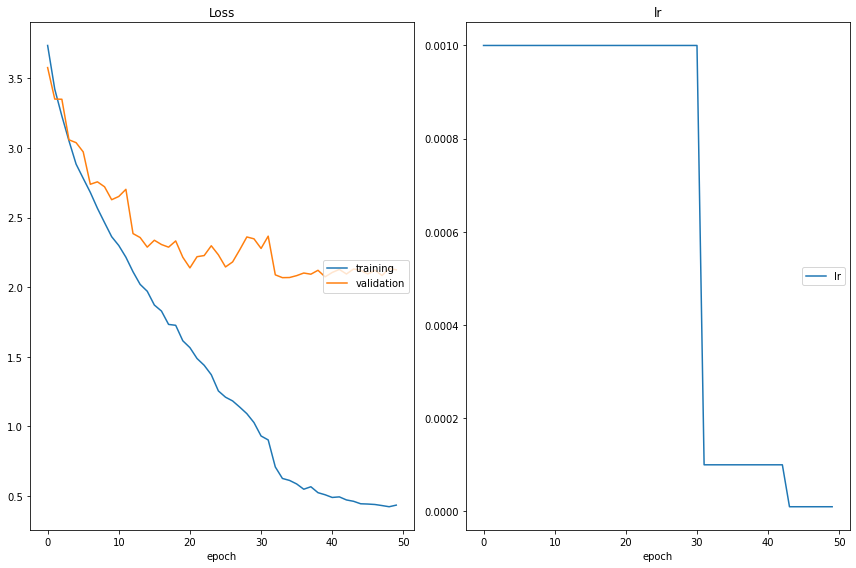

Loss
	training         	 (min:    0.422, max:    3.736, cur:    0.434)
	validation       	 (min:    2.068, max:    3.577, cur:    2.124)
lr
	lr               	 (min:    0.000, max:    0.001, cur:    0.000)


In [36]:
from src.data import get_data_loaders
from src.train import optimize
from src.optimization import get_optimizer, get_loss
from src.model import MyModel

# get the data loaders using batch_size and valid_size defined in the previous
# cell
data_loaders =  get_data_loaders(batch_size=batch_size, valid_size=valid_size)

# instance model MyModel with num_classes and drouput defined in the previous
# cell
model = MyModel(num_classes=num_classes, dropout=dropout)

optimizer = get_optimizer(model, learning_rate=learning_rate, optimizer=opt, weight_decay=weight_decay)

# Get the loss using get_loss
loss = get_loss()

optimize(
    data_loaders,
    model,
    optimizer,
    loss,
    n_epochs=num_epochs,
    save_path="checkpoints/best_val_loss.pt",
    interactive_tracking=True
)

---
## <img src="static_images/icons/noun-advance-2109145.png" alt=">" style="width:50px"/> Step 6: testing against the Test Set

In [37]:
# load the model that got the best validation accuracy
from src.train import one_epoch_test
from src.model import MyModel
import torch

model = MyModel(num_classes=num_classes, dropout=dropout)

model.load_state_dict(torch.load('checkpoints/best_val_loss.pt'))


# Run test
one_epoch_test(data_loaders['test'], model, loss)

Testing: 100%|██████████████████████████████████| 20/20 [00:07<00:00,  2.83it/s]

Test Loss: 1.976770


Test Accuracy: 53% (669/1250)


1.976769682765007

---
## <img src="static_images/icons/noun-advance-2109145.png" alt=">" style="width:50px"/> Step 7: Export using torchscript

Time to export it so I can use it in an app. I'll run another test to make sure it works.

In [38]:
!pytest -vv src/predictor.py

============================= test session starts ==============================
platform linux -- Python 3.9.16, pytest-7.1.1, pluggy-1.0.0 -- /opt/conda/bin/python3.9
cachedir: .pytest_cache
rootdir: /root
plugins: anyio-3.7.1
collected 1 item                                                               

src/predictor.py::test_model_construction PASSED                         [100%]

=============================== warnings summary ===============================
../opt/conda/lib/python3.9/site-packages/jupyter_client/connect.py:20
  /opt/conda/lib/python3.9/site-packages/jupyter_client/connect.py:20: DeprecationWarning: Jupyter is migrating its paths to use standard platformdirs
  given by the platformdirs library.  To remove this warning and
  see the appropriate new directories, set the environment variable
  `JUPYTER_PLATFORM_DIRS=1` and then run `jupyter --paths`.
  The use of platformdirs will be the default in `jupyter_core` v6
    from jupyter_core.paths import jupyter_data

Allright, now we are ready to export our model using the Predictor class:

In [46]:
# NOTE: you might need to restart the notebook before running this step
# If you get an error about RuntimeError: Can't redefine method: forward on class
# restart your notebook then execute only this cell
from src.predictor import Predictor
from src.helpers import compute_mean_and_std
from src.model import MyModel
from src.data import get_data_loaders
import torch

data_loaders = get_data_loaders(batch_size=1)

# First let's get the class names from our data loaders
class_names = data_loaders["train"].dataset.classes

# Then let's move the model_transfer to the CPU
# (we don't need GPU for inference)
model = MyModel(num_classes=50, dropout=0.5).cpu()

# Let's make sure we use the right weights by loading the
# best weights we have found during training
# NOTE: remember to use map_location='cpu' so the weights
# are loaded on the CPU (and not the GPU)

model.load_state_dict(torch.load("checkpoints/best_val_loss.pt", map_location='cpu'))

# Let's wrap our model using the predictor class
mean, std = compute_mean_and_std()
predictor = Predictor(model, class_names, mean, std).cpu()

# Export using torch.jit.script
scripted_predictor = torch.jit.script(predictor)

scripted_predictor.save("checkpoints/original_exported.pt")

Reusing cached mean and std
Dataset mean: tensor([0.4638, 0.4725, 0.4687]), std: tensor([0.2699, 0.2706, 0.3018])
Reusing cached mean and std


Finally, let's have a look at the confusion matrix of the model we are going to use in production:

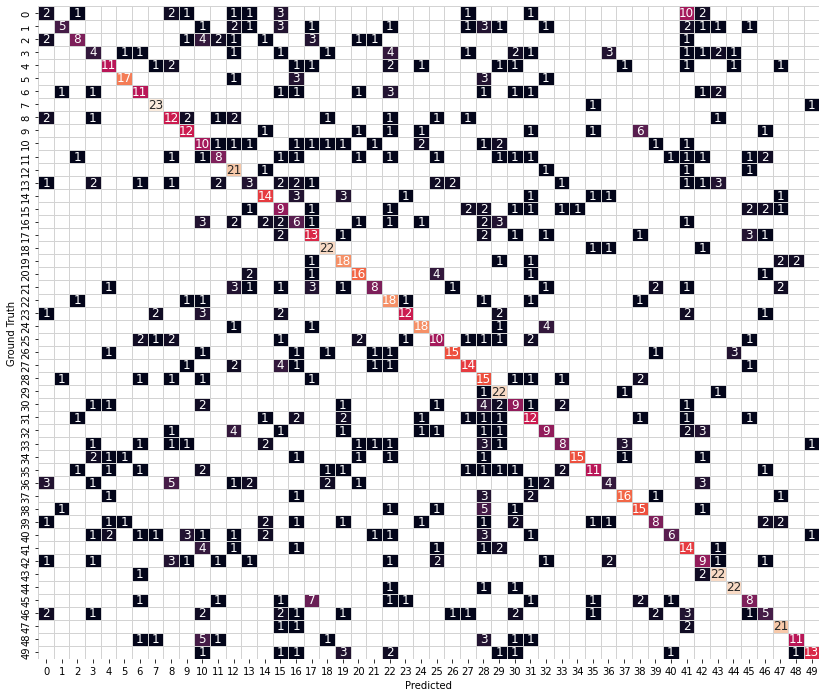

In [49]:
from src.helpers import plot_confusion_matrix

plot_confusion_matrix(pred, truth)